In this competition the challenge is to predict the return of a stock, given the history of the past few days. 

We provide 5-day windows of time, days D-2, D-1, D, D+1, and D+2. You are given returns in days D-2, D-1, and part of day D, and you are asked to predict the returns in the rest of day D, and in days D+1 and D+2.

During day D, there is intraday return data, which are the returns at different points in the day. We provide 180 minutes of data, from t=1 to t=180. In the training set you are given the full 180 minutes, in the test set just the first 120 minutes are provided.

For each 5-day window, we also provide 25 features, Feature_1 to Feature_25. These may or may not be useful in your prediction.

Each row in the dataset is an arbitrary stock at an arbitrary 5 day time window.

## File descriptions


train.csv - the training set, including the columns of:

Feature_1 - Feature_25<br>
Ret_MinusTwo, Ret_MinusOne<br>
Ret_2 - Ret_120<br>
Ret_121 - Ret_180: target variables<br>
Ret_PlusOne, Ret_PlusTwo: target variables<br>
Weight_Intraday, Weight_Daily<br>

test.csv - the test set, including the columns of:

Feature_1 - Feature_25<br>
Ret_MinusTwo, Ret_MinusOne<br>
Ret_2 - Ret_120<br>

sample_submission.csv - a sample submission file in the correct format

<H1>Graphical illusion of Data</H1>
<img src='https://storage.googleapis.com/kaggle-competitions/kaggle/4504/media/Presentation1%20(1).jpg'>
ref: https://storage.googleapis.com/kaggle-competitions/kaggle/4504/media/Presentation1%20(1).jpg

## Data fields

<b>Feature_1 to Feature_25</b>: different features relevant to prediction

<b>Ret_MinusTwo</b>:  this is the return from the close of trading on day D-2 to the close of trading on day D-1 (i.e. 1 day)

<b>Ret_MinusOne</b>: this is the return from the close of trading on day D-1 to the point at which the intraday returns start on day D (approximately 1/2 day)

<b>Ret_2 to Ret_120</b>: these are returns over approximately one minute on day D. Ret_2 is the return between t=1 and t=2. 

<b>Ret_121 to Ret_180</b>: intraday returns over approximately one minute on day D. These are the target variables you need to predict as {id}_{1-60}. 

<b>Ret_PlusOne</b>: this is the return from the time Ret_180 is measured on day D to the close of trading on day D+1. (approximately 1 day). This is a target variable you need to predict as {id}_61. 

<b>Ret_PlusTwo</b>: this is the return from the close of trading on day D+1 to the close of trading on day D+2 (i.e. 1 day) This is a target variable you need to predict as {id}_62. 

<b>Weight_Intraday</b>: weight used to evaluate intraday return predictions Ret 121 to 180

<b>Weight_Daily</b>: weight used to evaluate daily return predictions (Ret_PlusOne and Ret_PlusTwo).

## Metric

Submissions to this competition are judged on weighted mean absolute error, where each return
being predicted is compared with the actual return, scaled by its corresponding weight:

𝑊𝑀𝐴𝐸 =
1/𝑛 ∙
Σ𝑤𝑖 ∙ |𝑦𝑖 − 𝑦̂𝑖 |

where wi is the weight associated with the return, Weight_Intraday, Weight_Daily for intraday and daily returns, i, yi is the predicted return, 𝑦̂𝑖 is the actual return, n is the number of predictions. 

The weights for the training set are given in the training data. The weights for the test set are unknown.

In [0]:
!pip install transform

  Created wheel for transform: filename=Transform-0.0.1-cp36-none-any.whl size=2657 sha256=ac6069f1856d464ab4c6d4506777b6bb022465d7da482b8527cd7233d5a312ac
  Stored in directory: /root/.cache/pip/wheels/b2/3c/4c/54869afb2ddfcf16134da5e71a27070234029bc999816c3683
Successfully built transform


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer,StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from progressbar import ProgressBar
import xgboost as xgb

from sklearn import ensemble
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Masking
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau  

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


<h2>Colab session time check

In [7]:
import time, psutil
uptime = time.time() - psutil.boot_time()
remain = 12*60*60 - uptime
print(remain/3600)

11.81664834075504


In [8]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [9]:
# downloading the kaggle data
!kaggle competitions download -c the-winton-stock-market-challenge

 95% 69.0M/72.7M [00:01<00:00, 28.8MB/s]
100% 72.7M/72.7M [00:01<00:00, 41.9MB/s]
 56% 9.00M/16.1M [00:01<00:00, 11.7MB/s]
100% 16.1M/16.1M [00:01<00:00, 15.1MB/s]
 92% 105M/114M [00:01<00:00, 57.3MB/s] 
100% 114M/114M [00:01<00:00, 60.8MB/s]


In [10]:
!unzip train.csv.zip
!unzip test_2.csv.zip
!unzip sample_submission_2.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
   creating: __MACOSX/
  inflating: __MACOSX/._train.csv    
Archive:  test_2.csv.zip
  inflating: test_2.csv              
  inflating: __MACOSX/._test_2.csv   
Archive:  sample_submission_2.csv.zip
  inflating: sample_submission_2.csv  
  inflating: __MACOSX/._sample_submission_2.csv  


<h1>Exploratory data analysis and Data preprocessing

In [0]:
from prettytable import PrettyTable
conc = PrettyTable(["Model Name", "MSE for daily returns", "MSE for intra day returns"])

In [11]:
files_path=''
df=pd.read_csv(files_path+"train.csv")
df.head()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Ret_MinusTwo,Ret_MinusOne,Ret_2,Ret_3,Ret_4,Ret_5,Ret_6,Ret_7,Ret_8,Ret_9,Ret_10,Ret_11,Ret_12,Ret_13,...,Ret_145,Ret_146,Ret_147,Ret_148,Ret_149,Ret_150,Ret_151,Ret_152,Ret_153,Ret_154,Ret_155,Ret_156,Ret_157,Ret_158,Ret_159,Ret_160,Ret_161,Ret_162,Ret_163,Ret_164,Ret_165,Ret_166,Ret_167,Ret_168,Ret_169,Ret_170,Ret_171,Ret_172,Ret_173,Ret_174,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,1,NaN,NaN,NaN,NaN,8.0,NaN,75751,0.2254,11.0,NaN,NaN,0.49,5.0,1.842984,27.053679,1.0,NaN,NaN,-0.925463,2.0,NaN,-0.489492,NaN,NaN,NaN,0.055275,-0.010770,0.000003,-0.000734,-0.000738,-0.000007,0.000423,0.000438,-0.000076,0.000645,-0.000006,0.000006,NaN,-0.000156,...,-0.000842,-0.001390,0.000148,2.846942e-04,0.001254,-0.000130,0.000126,0.000978,0.000151,0.002642,-0.000017,0.000140,0.000015,-0.000011,0.001683,-0.000286,0.000010,0.000152,0.000579,-1.501973e-04,0.000822,0.001392,0.000292,0.000002,0.001133,-0.000134,0.001539,-0.000142,0.000861,0.000544,-0.002688,0.002246,-0.000838,-6.953224e-04,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
1,2,NaN,NaN,NaN,NaN,3.0,0.388896,17369,0.0166,13.0,NaN,-0.409923,0.71,9.0,1.577586,9.546915,1.0,-0.949891,0.917958,-0.897067,9.0,0.886205,-0.151805,1.239856,0.953424,-0.709462,0.009748,0.002987,-0.000487,0.000475,0.000002,-0.000002,-0.000523,-0.000255,-0.000008,0.000048,-0.000312,-0.000742,-0.000009,-0.000248,...,-0.000104,0.000555,0.000259,2.559339e-05,0.000004,-0.000255,0.000263,0.000250,0.000104,0.000119,-0.000483,0.000128,0.000886,0.000003,0.000148,0.000623,0.000507,-0.000742,-0.000514,8.881545e-07,0.000090,-0.000361,-0.000738,-0.000502,0.000497,0.000256,-0.000256,-0.000005,-0.000497,0.000240,-0.000129,0.000123,0.000248,3.315418e-07,0.000003,0.000027,-0.002939,-0.010253,1.733950e+06,2.167438e+06
2,3,NaN,-0.696727,0.739591,-0.167928,9.0,0.471947,8277,0.3650,9.0,5.0,-0.473024,0.03,6.0,1.871160,9.647559,1.0,-1.132426,1.799813,-1.603488,3.0,NaN,0.389061,1.728096,-1.798090,-1.019370,0.003077,0.006181,-0.000782,-0.000402,0.000807,0.000400,0.000656,-0.001177,0.001198,0.000610,-0.001031,0.000647,-0.000930,-0.000543,...,-0.000003,-0.000102,-0.000292,5.032658e-04,-0.000126,-0.000135,0.000238,-0.000106,-0.000137,-0.000419,-0.000379,0.000013,0.000001,-0.000009,-0.000283,-0.000526,0.000247,-0.000134,0.000675,1.136847e-04,0.000234,-0.000506,-0.000007,-0.000249,0.000119,0.000277,0.000656,0.000127,0.000255,0.000278,-0.000524,-0.000394,0.000116,5.322557e-04,0.000274,0.000784,-0.024791,0.015711,1.529197e+06,1.911497e+06
3,4,NaN,-0.694350,1.568248,0.479073,5.0,0.120653,22508,0.2654,13.0,5.0,-2.138383,0.00,6.0,NaN,1.801865,1.0,-1.131213,1.565036,NaN,7.0,1.148738,-2.440799,1.551425,-1.788725,NaN,0.000984,0.014106,0.000277,-0.000088,-0.000199,-0.000301,0.000711,-0.000431,-0.000144,0.000340,-0.000639,0.000420,0.000145,-0.000130,...,0.000120,-0.000119,0.000285,-1.020028e-07,0.000285,-0.000350,0.000214,-0.000703,0.000153,-0.000286,0.000136,-0.000579,-0.000139,-0.000005,-0.000009,0.000010,0.000290,-0.000068,-0.000352,2.739541e-04,-0.000292,0.000446,0.000288,0.000001,0.000304,-0.000027,0.000371,-0.000055,-0.000161,-0.000155,0.000346,-0.000090,0.000288,-1.281102e-04,0.000074,0.000341,-0.005680,-0.002190,1.711569e+06,2.139462e+06
4,5,6.0,-1.736489,2.765531,1.245280,7.0,4.866985,22423,0.2138,13.0,4.0,-4.795565,0.97,5.0,0.842102,9.198895,1.0,6.317498,-3.208872,-1.102189,7.0,3.381040,1.732708,1.965189,-5.993092,3.219820,-0.018224,0.011065,-0.001232,0.000002,-0.001205,-0.000021,0.000005,0.000623,-0.001843,0.000005,0.001226,0.001213,-0.002428,0.000974,...,-0.000979,0.000978,-0.000014,-1.218838e-03,0.001208,-0.000013,-0.000620,0.000606,-0.001238,0.000002,0.000003,-0.001226,0.001005,-0.000008,0.000231,-0.000

In [0]:
# the shape of train data
df.shape

(40000, 211)

In [0]:
# https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe
count_nan = len(df) - df.count()
print(count_nan[:5])
print(df.count()[:5])

Id               0
Feature_1    33313
Feature_2     9146
Feature_3     1237
Feature_4     7721
dtype: int64
Id           40000
Feature_1     6687
Feature_2    30854
Feature_3    38763
Feature_4    32279
dtype: int64


In [0]:
# as we can see there are many nan values so replacing the values with mean
len(count_nan)

211

In [0]:
# https://medium.com/better-programming/handling-missing-data-in-python-using-scikit-imputer-7607c8957740

#  replacing NaN values

imputer = Imputer(missing_values="NaN", strategy="mean", axis = 0)
imputer = imputer.fit(df.values)
df_ar = imputer.transform(df)

# imputer will return the numpy arrays
df.fillna(df.mean(axis=0), inplace=True)
# we are using the above line because it reatains the datatype as Dataframe and in future code 
#    it will be easy to access through column names

In [0]:
df_ar[:5]

array([[ 1.00000000e+00,  3.59024974e+00, -1.17557876e-01, ...,
         2.88463645e-02,  1.25150797e+06,  1.56438496e+06],
       [ 2.00000000e+00,  3.59024974e+00, -1.17557876e-01, ...,
        -1.02532062e-02,  1.73395035e+06,  2.16743794e+06],
       [ 3.00000000e+00,  3.59024974e+00, -6.96726938e-01, ...,
         1.57107386e-02,  1.52919738e+06,  1.91149673e+06],
       [ 4.00000000e+00,  3.59024974e+00, -6.94349689e-01, ...,
        -2.19045788e-03,  1.71156942e+06,  2.13946178e+06],
       [ 5.00000000e+00,  6.00000000e+00, -1.73648913e+00, ...,
        -2.65516002e-02,  1.26727026e+06,  1.58408783e+06]])

In [0]:
df.head()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Ret_MinusTwo,Ret_MinusOne,Ret_2,Ret_3,Ret_4,Ret_5,Ret_6,Ret_7,Ret_8,Ret_9,Ret_10,Ret_11,Ret_12,Ret_13,...,Ret_145,Ret_146,Ret_147,Ret_148,Ret_149,Ret_150,Ret_151,Ret_152,Ret_153,Ret_154,Ret_155,Ret_156,Ret_157,Ret_158,Ret_159,Ret_160,Ret_161,Ret_162,Ret_163,Ret_164,Ret_165,Ret_166,Ret_167,Ret_168,Ret_169,Ret_170,Ret_171,Ret_172,Ret_173,Ret_174,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,1,3.59025,-0.117558,0.558392,0.405572,8.0,0.430972,75751,0.2254,11.0,4.744703,-0.572244,0.49,5.0,1.842984,27.053679,1.0,-0.549725,0.803059,-0.925463,2.0,0.605593,-0.489492,0.799833,-1.209290,-0.329675,0.055275,-0.010770,0.000003,-0.000734,-0.000738,-0.000007,0.000423,0.000438,-0.000076,0.000645,-0.000006,0.000006,4.886832e-07,-0.000156,...,-0.000842,-0.001390,0.000148,2.846942e-04,0.001254,-0.000130,0.000126,0.000978,0.000151,0.002642,-0.000017,0.000140,0.000015,-0.000011,0.001683,-0.000286,0.000010,0.000152,0.000579,-1.501973e-04,0.000822,0.001392,0.000292,0.000002,0.001133,-0.000134,0.001539,-0.000142,0.000861,0.000544,-0.002688,0.002246,-0.000838,-6.953224e-04,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
1,2,3.59025,-0.117558,0.558392,0.405572,3.0,0.388896,17369,0.0166,13.0,4.744703,-0.409923,0.71,9.0,1.577586,9.546915,1.0,-0.949891,0.917958,-0.897067,9.0,0.886205,-0.151805,1.239856,0.953424,-0.709462,0.009748,0.002987,-0.000487,0.000475,0.000002,-0.000002,-0.000523,-0.000255,-0.000008,0.000048,-0.000312,-0.000742,-9.027256e-06,-0.000248,...,-0.000104,0.000555,0.000259,2.559339e-05,0.000004,-0.000255,0.000263,0.000250,0.000104,0.000119,-0.000483,0.000128,0.000886,0.000003,0.000148,0.000623,0.000507,-0.000742,-0.000514,8.881545e-07,0.000090,-0.000361,-0.000738,-0.000502,0.000497,0.000256,-0.000256,-0.000005,-0.000497,0.000240,-0.000129,0.000123,0.000248,3.315418e-07,0.000003,0.000027,-0.002939,-0.010253,1.733950e+06,2.167438e+06
2,3,3.59025,-0.696727,0.739591,-0.167928,9.0,0.471947,8277,0.3650,9.0,5.000000,-0.473024,0.03,6.0,1.871160,9.647559,1.0,-1.132426,1.799813,-1.603488,3.0,0.605593,0.389061,1.728096,-1.798090,-1.019370,0.003077,0.006181,-0.000782,-0.000402,0.000807,0.000400,0.000656,-0.001177,0.001198,0.000610,-0.001031,0.000647,-9.295448e-04,-0.000543,...,-0.000003,-0.000102,-0.000292,5.032658e-04,-0.000126,-0.000135,0.000238,-0.000106,-0.000137,-0.000419,-0.000379,0.000013,0.000001,-0.000009,-0.000283,-0.000526,0.000247,-0.000134,0.000675,1.136847e-04,0.000234,-0.000506,-0.000007,-0.000249,0.000119,0.000277,0.000656,0.000127,0.000255,0.000278,-0.000524,-0.000394,0.000116,5.322557e-04,0.000274,0.000784,-0.024791,0.015711,1.529197e+06,1.911497e+06
3,4,3.59025,-0.694350,1.568248,0.479073,5.0,0.120653,22508,0.2654,13.0,5.000000,-2.138383,0.00,6.0,1.588524,1.801865,1.0,-1.131213,1.565036,-1.205438,7.0,1.148738,-2.440799,1.551425,-1.788725,-0.329675,0.000984,0.014106,0.000277,-0.000088,-0.000199,-0.000301,0.000711,-0.000431,-0.000144,0.000340,-0.000639,0.000420,1.449000e-04,-0.000130,...,0.000120,-0.000119,0.000285,-1.020028e-07,0.000285,-0.000350,0.000214,-0.000703,0.000153,-0.000286,0.000136,-0.000579,-0.000139,-0.000005,-0.000009,0.000010,0.000290,-0.000068,-0.000352,2.739541e-04,-0.000292,0.000446,0.000288,0.000001,0.000304,-0.000027,0.000371,-0.000055,-0.000161,-0.000155,0.000346,-0.000090,0.000288,-1.281102e-04,0.000074,0.000341,-0.005680,-0.002190,1.711569e+06,2.139462e+06
4,5,6.00000,-1.736489,2.765531,1.245280,7.0,4.866985,22423,0.2138,13.0,4.000000,-4.795565,0.97,5.0,0.842102,9.198895,1.0,6.317498,-3.208872,-1.102189,7.0,3.381040,1.732708,1.965189,-5.993092,3.219820,-0.018224,0.011065,-0.001232,0.000002,-0.001205,-0.000021,0.000005,0.000623,-0.001843,0.000005,0.001226,0.001213,-2.428211e-0

In [0]:
df.describe()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Ret_MinusTwo,Ret_MinusOne,Ret_2,Ret_3,Ret_4,Ret_5,Ret_6,Ret_7,Ret_8,Ret_9,Ret_10,Ret_11,Ret_12,Ret_13,...,Ret_145,Ret_146,Ret_147,Ret_148,Ret_149,Ret_150,Ret_151,Ret_152,Ret_153,Ret_154,Ret_155,Ret_156,Ret_157,Ret_158,Ret_159,Ret_160,Ret_161,Ret_162,Ret_163,Ret_164,Ret_165,Ret_166,Ret_167,Ret_168,Ret_169,Ret_170,Ret_171,Ret_172,Ret_173,Ret_174,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
count,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.000000,4.000000e+04,40000.000000,...,40000.000000,40000.000000,4.000000e+04,40000.000000,4.000000e+04,40000.000000,4.000000e+04,4.000000e+04,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.000000,40000.000000,4.000000e+04,4.000000e+04,40000.000000,4.000000e+04,40000.000000,40000.000000,4.000000e+04,40000.000000,4.000000e+04,4.000000e+04,4.000000e+04,40000.000000,40000.000000,40000.000000,40000.000000,4.000000e+04,4.000000e+04
mean,20000.50000,3.590250,-0.117558,0.558392,0.405572,5.482775,0.430972,49244.971525,0.196958,10.680289,4.744703,-0.572244,0.498508,4.238162,1.588524,3.891381,1.007362,-0.549725,0.803059,-1.205438,5.267359,0.605593,-0.773089,0.799833,-1.209290,-0.329675,0.000784,-0.000803,5.600930e-06,-0.000008,-0.000006,-0.000006,-0.000019,0.000030,0.000028,4.696042e-07,0.000004,-0.000004,4.886832e-07,0.000010,...,-0.000013,-0.000017,3.491875e-06,0.000040,8.892747e-06,-0.000014,4.984467e-08,-6.966570e-06,-0.000038,0.000005,-9.939315e-06,-0.000011,-0.000062,7.202898e-06,-0.000010,0.000046,2.717110e-05,-0.000016,-0.000034,-1.687919e-05,0.000006,-0.000044,0.000057,9.070996e-07,1.837518e-05,0.000017,6.297943e-06,-0.000032,0.000034,-1.729004e-05,0.000049,-3.580980e-06,-9.675766e-06,-1.268935e-05,-0.000017,-0.000057,-0.000210,0.000012,1.504600e+06,1.880750e+06
std,11547.14972,1.144166,1.085751,0.888172,0.717828,2.942324,1.461623,28242.409717,0.137671,2.783019,0.619745,1.230874,0.347001,2.551335,0.314010,4.898465,0.084834,0.929237,1.157137,0.632798,2.286282,1.302263,1.365673,1.260190,1.723796,0.950779,0.028279,0.030569,9.375506e-04,0.000960,0.000979,0.000947,0.000909,0.000992,0.000907,9.359933e-04,0.000972,0.000964,9.424911e-04,0.000902,...,0.001177,0.001108,1.167113e-03,0.001090,1.197600e-03,0.001232,1.131458e-03,1.236089e-03,0.001187,0.001164,1.098337e-03,0.001068,0.001317,1.185004e-03,0.001199,0.001128,1.219576e-03,0.001498,0.001211,1.241690e-03,0.001183,0.001179,0.001254,1.178561e-03,1.120816e-03,0.001128,1.267855e-03,0.001304,0.001161,1.148816e-03,0.001115,1.166019e-03,1.248956e-03,1.217967e-03,0.001208,0.001270,0.025039,0.024160,2.059143e+05,2.573928e+05
min,1.00000,1.000000,-3.440521,-4.643526,-5.440596,1.000000,-0.936644,338.000000,0.009800,0.000000,1.000000,-7.359120,0.000000,0.000000,-0.149272,0.021679,1.000000,-2.613987,-5.758047,-3.292909,2.000000,-1.514998,-5.819912,-7.221387,-11.442205,-1.903876,-0.536283,-0.514720,-1.311777e-02,-0.038542,-0.040386,-0.030359,-0.024735,-0.056589,-0.019753,-2.955805e-02,-0.030077,-0.015547,-2.379214e-02,-0.021081,...,-0.029957,-0.036449,-4.893908e-02,-0.013661,-2.518124e-02,-0.037844,-6.427263e-02,-3.186576e-02,-0.037489,-0.027112,-2.948088e-02,-0.025035,-0.062718,-5.12039

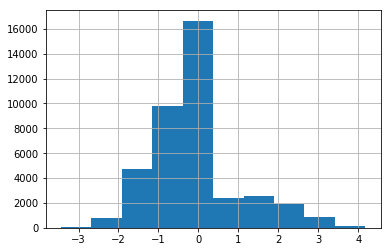

In [0]:
df['Feature_2'].hist()

<h3> PLotting Intra day returns and Faily Returns

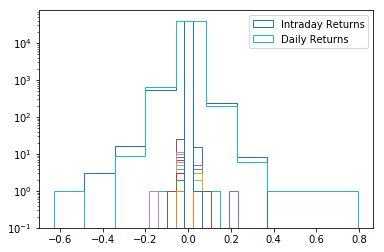

In [0]:
# https://github.com/higgsb0/winton-stock/blob/master/stock-prediction.html
plt.hist(df.loc[:, 'Ret_2':'Ret_180'].values, log=True,
        histtype='step', label='Intraday Returns')
plt.hist(df.loc[:,'Ret_PlusOne':'Ret_PlusTwo'].values, log=True,
        histtype='step', label='Daily Returns')
plt.legend()
plt.show()

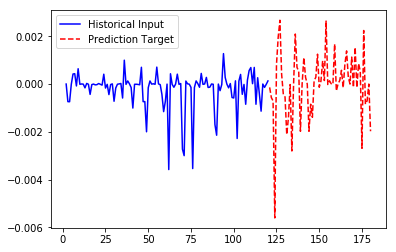

In [0]:
# https://github.com/higgsb0/winton-stock/blob/master/stock-prediction.html
plt.plot(range(2,121),df.iloc[0]['Ret_2':'Ret_120'], 'b-', label='Historical Input')
plt.plot(range(121,181),df.iloc[0]['Ret_121':'Ret_180'], 'r--', label='Prediction Target')
plt.legend()
plt.show()

<H1> Applying PCA 

CPU times: user 320 ms, sys: 211 ms, total: 531 ms
Wall time: 331 ms


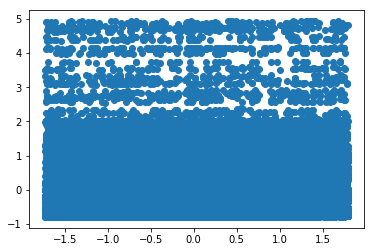

In [0]:
%%time
%matplotlib inline

from sklearn.decomposition import PCA
pca = PCA(n_components=5,whiten=True)
X = df.loc[:,'Feature_1':'Feature_25'].values
X_r = pca.fit_transform(X)
plt.scatter(X_r[:,0], X_r[:,1])

In [0]:
pca.explained_variance_

array([7.97633707e+08, 2.39965424e+01, 1.43961516e+01, 7.75598275e+00,
       6.71316629e+00])

In [0]:
submission_df=pd.read_csv(files_path+"sample_submission_2.csv")
submission_df.head()

,Id,Predicted
0,1_1,0
1,1_2,0
2,1_3,0
3,1_4,0
4,1_5,0


In [0]:
submission_df['Id'].values[0:63]

array(['1_1', '1_2', '1_3', '1_4', '1_5', '1_6', '1_7', '1_8', '1_9',
       '1_10', '1_11', '1_12', '1_13', '1_14', '1_15', '1_16', '1_17',
       '1_18', '1_19', '1_20', '1_21', '1_22', '1_23', '1_24', '1_25',
       '1_26', '1_27', '1_28', '1_29', '1_30', '1_31', '1_32', '1_33',
       '1_34', '1_35', '1_36', '1_37', '1_38', '1_39', '1_40', '1_41',
       '1_42', '1_43', '1_44', '1_45', '1_46', '1_47', '1_48', '1_49',
       '1_50', '1_51', '1_52', '1_53', '1_54', '1_55', '1_56', '1_57',
       '1_58', '1_59', '1_60', '1_61', '1_62', '2_1'], dtype=object)

In [0]:
submission_df.shape
# there are 120000 id's and  62 return values for each id 62 *120000 = 7440000

(7440000, 2)

<h1>Models

<H1>Data Preprocessing

In [0]:

first = ['Id']
allcol = ['Ret_121','Ret_122','Ret_123','Ret_124','Ret_125','Ret_126','Ret_127','Ret_128','Ret_129','Ret_130',
'Ret_131','Ret_132','Ret_133','Ret_134','Ret_135','Ret_136','Ret_137','Ret_138','Ret_139','Ret_140','Ret_141',
'Ret_142','Ret_143','Ret_144','Ret_145','Ret_146','Ret_147','Ret_148','Ret_149','Ret_150','Ret_151','Ret_152',
'Ret_153','Ret_154','Ret_155','Ret_156','Ret_157','Ret_158','Ret_159','Ret_160','Ret_161','Ret_162','Ret_163',
'Ret_164','Ret_165','Ret_166','Ret_167','Ret_168','Ret_169','Ret_170','Ret_171','Ret_172','Ret_173','Ret_174',
'Ret_175','Ret_176','Ret_177','Ret_178','Ret_179','Ret_180','Ret_PlusOne','Ret_PlusTwo']

total = first + allcol
feature_cols = [col for col in df.columns if col not in total] 

X = df[feature_cols] # .loc[:, 'Feature_1':'Ret_120'] 
y = df[allcol] #.loc[:, 'Ret_121':'Weight_Daily'] 

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
intraDay_cols = ['Ret_PlusOne','Ret_PlusTwo']

dailyReturn_cols = ['Ret_121','Ret_122','Ret_123','Ret_124','Ret_125','Ret_126','Ret_127','Ret_128','Ret_129','Ret_130',
'Ret_131','Ret_132','Ret_133','Ret_134','Ret_135','Ret_136','Ret_137','Ret_138','Ret_139','Ret_140','Ret_141',
'Ret_142','Ret_143','Ret_144','Ret_145','Ret_146','Ret_147','Ret_148','Ret_149','Ret_150','Ret_151','Ret_152',
'Ret_153','Ret_154','Ret_155','Ret_156','Ret_157','Ret_158','Ret_159','Ret_160','Ret_161','Ret_162','Ret_163',
'Ret_164','Ret_165','Ret_166','Ret_167','Ret_168','Ret_169','Ret_170','Ret_171','Ret_172','Ret_173','Ret_174',
'Ret_175','Ret_176','Ret_177','Ret_178','Ret_179','Ret_180']

In [0]:
y_train_raw.shape

(32000, 62)

In [0]:
def preprocess_data(x_raw, y_raw):
    # top 25 features
    features = x_raw.loc[:, 'Feature_1':'Feature_25'].values[:, None, :]

    # 120 return values
    returns_intraday = x_raw.loc[:, 'Ret_2':'Ret_120'].values[:, :, None]
    print("No of repeatitions : ",returns_intraday.shape[1])
    
    features_repeated = np.repeat(features, returns_intraday.shape[1], axis=1)
    X_intraday = np.dstack((features_repeated, returns_intraday))
    
    returns_daily = x_raw.loc[:, 'Ret_MinusTwo':'Ret_MinusOne'].values[:, :, None]
    print("No of repeatitions : ",returns_daily.shape[1])
    features_repeated = np.repeat(features, returns_daily.shape[1], axis=1)
    X_daily = np.dstack((features_repeated, returns_daily))
    
    # targets should consist of returns only
    y_intraday = y_raw.loc[:, 'Ret_121':'Ret_180']
    y_daily = y_raw.loc[:, 'Ret_PlusOne':'Ret_PlusTwo']
    
    return X_intraday, X_daily, y_intraday, y_daily

In [0]:
X_train_intraday, X_train_daily, y_train_intraday, y_train_daily = preprocess_data(X_train_raw, y_train_raw)    
X_test_intraday, X_test_daily, y_test_intraday, y_test_daily= preprocess_data(X_test_raw, y_test_raw)

No of repeatitions :  119
No of repeatitions :  2
No of repeatitions :  119
No of repeatitions :  2


In [0]:
print("X_train_intraday.shape :",X_train_intraday.shape)
print("X_train_daily.shape :",X_train_daily.shape)

X_train_intraday.shape : (32000, 119, 26)
X_train_daily.shape : (32000, 2, 26)


In [0]:
X_train_intraday[:2][:2][:2]

array([[[            nan, -1.09807731e+00,  1.43122925e-01, ...,
         -1.33675658e+00, -1.31101549e-01,  8.63062304e-04],
        [            nan, -1.09807731e+00,  1.43122925e-01, ...,
         -1.33675658e+00, -1.31101549e-01, -2.64819597e-04],
        [            nan, -1.09807731e+00,  1.43122925e-01, ...,
         -1.33675658e+00, -1.31101549e-01,  2.92963178e-04],
        ...,
        [            nan, -1.09807731e+00,  1.43122925e-01, ...,
         -1.33675658e+00, -1.31101549e-01, -1.14146922e-03],
        [            nan, -1.09807731e+00,  1.43122925e-01, ...,
         -1.33675658e+00, -1.31101549e-01, -2.55115231e-03],
        [            nan, -1.09807731e+00,  1.43122925e-01, ...,
         -1.33675658e+00, -1.31101549e-01, -3.03053183e-06]],

       [[            nan, -5.48323039e-01,  2.65133173e-02, ...,
                     nan, -5.30744054e-01, -7.00989192e-06],
        [            nan, -5.48323039e-01,  2.65133173e-02, ...,
                     nan, -5.30744054e

<H2>1. LSTM with masking layers

In [0]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='relu',
                     dropout=.4, loss='mae', loss_weights=None, sample_weight_mode=None,
                     optimizer='adam'):
    model = Sequential()
    # https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs
    # https://www.quora.com/What-is-masking-in-a-recurrent-neural-network-RNN
    model.add(Masking(mask_value=0., input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))

    model.add(Dropout(dropout))
    model.add(Dense(units=2 * neurons))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, loss_weights=loss_weights, sample_weight_mode=sample_weight_mode, optimizer=optimizer)
    print(model.summary())
    return model

<h4>a. Model for daily returns


In [0]:
lstm_neurons = 100
epochs = 3
batch_size = 500
loss = 'mse'
dropout = 0.20

checkpointer_daily = ModelCheckpoint(filepath='best_weights_daily.hdf5', 
                               verbose=1, save_best_only=True)
model_daily = build_lstm_model(X_train_daily, y_train_daily.shape[1], neurons=lstm_neurons, 
                               activ_func='relu', optimizer='adam',
                               dropout=0.3)
history_daily = model_daily.fit(X_train_daily, y_train_daily, validation_split=0.25, batch_size=batch_size, 
                           verbose=1, shuffle=True,
                          epochs=epochs, callbacks=[checkpointer_daily])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 2, 26)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               50800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                

In [0]:
m1= mean_squared_error(model_daily.predict(X_test_daily), y_test_daily)
print("MSE error :"m1)

0.000650198712438325


In [0]:
model_daily.predict(X_test_daily)

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

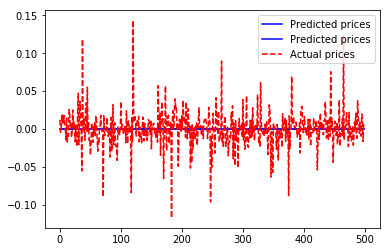

In [0]:
plt.plot(range(0, len(y_test_daily[:500])), model_daily.predict(X_test_daily)[:500], 'b-', label='Predicted prices')
plt.plot(range(0, len(y_test_daily[:500])),y_test_daily['Ret_PlusOne'][:500], 'r--', label='Actual prices')
plt.legend()
plt.show()

b. Model for intra day returns

In [0]:
lstm_neurons = 250
epochs = 3
batch_size = 500
loss = 'mae'
dropout = 0.20
optimizer = 'adam'
activ_func = 'relu'

checkpointer_intraday = ModelCheckpoint(filepath='best_weights_intraday.hdf5', 
                               verbose=1, save_best_only=True)
model_intraday = build_lstm_model(X_train_intraday, y_train_intraday.shape[1], neurons=lstm_neurons, 
                               activ_func=activ_func, optimizer=optimizer,
                               dropout=dropout)
history_intraday = model_intraday.fit(X_train_intraday, y_train_intraday, validation_split=0.25, batch_size=batch_size, 
                           verbose=1, shuffle=True,
                          epochs=epochs, callbacks=[checkpointer_intraday])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 119, 26)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 250)               277000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               125500    
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 60)                30060     
_________________________________________________________________
activation_3 (Activation)    (None, 60)               

In [0]:
y_pred=model_intraday.predict(X_test_intraday)
m2= mean_squared_error(y_pred, y_test_intraday)
print("MSE error :"m2)

1.2613788683900336e-06


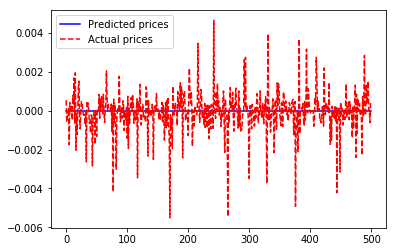

In [0]:
plt.plot(range(0, 500), y_pred[:,0][:500], 'b-', label='Predicted prices')
plt.plot(range(0, 500),y_test_intraday['Ret_121'][:500], 'r--', label='Actual prices')
plt.legend()

In [0]:
conc.add_row(["LSTM With masking layer", m1, m2])
print(conc)

+-------------------------+---------------------------+------------------------+
|        Model Name       | MSE for intra day returns | MSE for daily returns  |
+-------------------------+---------------------------+------------------------+
| LSTM With masking layer |    0.000650198712438325   | 1.2613788683900336e-06 |
+-------------------------+---------------------------+------------------------+


No of repeatitions :  119
No of repeatitions :  2
No of repeatitions :  119
No of repeatitions :  2
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_10 (Masking)         (None, 2, 26)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               50800     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 402       
___________________

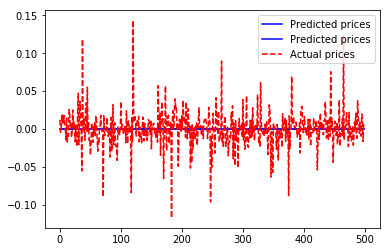

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_11 (Masking)         (None, 119, 26)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 250)               277000    
_________________________________________________________________
dropout_21 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 500)               125500    
_________________________________________________________________
dropout_22 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 60)                30060     
_________________________________________________________________
activation_11 (Activation)   (None, 60)              

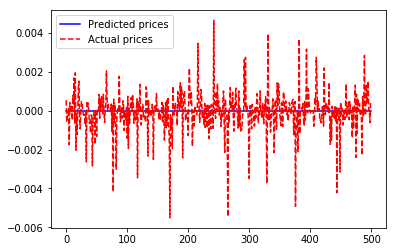

In [0]:

# feature_cols = [col for col in df.columns if col not in total] 
# X = df[feature_cols] 
# y = df[allcol] 
# X.fillna(X.median(axis=0), inplace=True)
# y.fillna(y.mean(axis=0), inplace=True)

# X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.20, random_state=42)
# X_train_intraday, X_train_daily, y_train_intraday, y_train_daily = preprocess_data(X_train_raw, y_train_raw)    
# X_test_intraday, X_test_daily, y_test_intraday, y_test_daily= preprocess_data(X_test_raw, y_test_raw)

# lstm_neurons = 100
# epochs = 3
# batch_size = 500
# loss = 'mse'
# dropout = 0.20

# checkpointer_daily = ModelCheckpoint(filepath='best_weights_daily.hdf5', 
#                                verbose=1, save_best_only=True)
# model_daily = build_lstm_model(X_train_daily, y_train_daily.shape[1], neurons=lstm_neurons, 
#                                activ_func='relu', optimizer='adam',
#                                dropout=0.3)
# history_daily = model_daily.fit(X_train_daily, y_train_daily, validation_split=0.25, batch_size=batch_size, 
#                            verbose=1, shuffle=True,
#                           epochs=epochs, callbacks=[checkpointer_daily])
						  
# m1= mean_squared_error(model_daily.predict(X_test_daily), y_test_daily)
# print(m1)
# model_daily.predict(X_test_daily)
# plt.plot(range(0, len(y_test_daily[:500])), model_daily.predict(X_test_daily)[:500], 'b-', label='Predicted prices')
# plt.plot(range(0, len(y_test_daily[:500])),y_test_daily['Ret_PlusOne'][:500], 'r--', label='Actual prices')
# plt.legend()
# plt.show()

# lstm_neurons = 250
# epochs = 3
# batch_size = 500
# loss = 'mae'
# dropout = 0.20
# optimizer = 'adam'
# activ_func = 'relu'

# checkpointer_intraday = ModelCheckpoint(filepath='best_weights_intraday.hdf5', 
#                                verbose=1, save_best_only=True)
# model_intraday = build_lstm_model(X_train_intraday, y_train_intraday.shape[1], neurons=lstm_neurons, 
#                                activ_func=activ_func, optimizer=optimizer,
#                                dropout=dropout)
# history_intraday = model_intraday.fit(X_train_intraday, y_train_intraday, validation_split=0.25, batch_size=batch_size, 
#                            verbose=1, shuffle=True,
#                           epochs=epochs, callbacks=[checkpointer_intraday])
						  
# y_pred=model_intraday.predict(X_test_intraday)
# m2= mean_squared_error(y_pred, y_test_intraday)
# print(m2)

# plt.plot(range(0, 500), y_pred[:,0][:500], 'b-', label='Predicted prices')
# plt.plot(range(0, 500),y_test_intraday['Ret_121'][:500], 'r--', label='Actual prices')
# plt.legend()

# conc.add_row(["LSTM With masking layer and replacing NaN with median", m1, m2])
# print(conc)	

The above model doesn't get improve if we replace the NaN values with median and mean

<h2> 2. XGBoost

In [0]:
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
msk = np.random.rand(len(training_csv)) < 0.8
print(msk)
training_csv = df[msk]
testing_csv = df[~msk]

# training_data = training_csv.drop(training_csv.columns[range(146, 210)], axis=1)
# testing_csv = testing_csv.drop(testing_csv.columns[range(146, 210)], axis=1)

[False  True  True ...  True  True  True]


<h4>a. Daily returns

In [1]:
%%time

model_parameters = {'max_depth': 10, 
                    'eta': 0.1,
                    'silent': 1, 
                    'gamma': 0, 
                    'lambda': 500,
                    'alpha': 400,
                    'verbose':0}
number_of_rounds = 500
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
msk = np.random.rand(len(df)) < 0.8
print(msk)
training_csv = df[msk]
testing_csv = df[~msk]
res =  pd.DataFrame()

mse_list=[]
major_list=[]
pro =ProgressBar()

training_data = training_csv.drop(training_csv.columns[range(146, 210)], axis=1)
testing_data = testing_csv.drop(testing_csv.columns[range(146, 210)], axis=1)

training_data = training_data.values
testing_data = testing_data.values

# as we plot only Ret_1 for every model to compare test prediction and actual value
plot_res =  pd.DataFrame()
for Number in pro(range(1,61)): # From 1 to 62

    name_of_column = 'Ret_'+str(Number+120)
    name_of_weight = 'Weight_Intraday'

    train_targets = training_csv[name_of_column].values
    test_targets = testing_csv[name_of_column].values

    train_weights = training_csv[name_of_weight].values

    data_train = xgb.DMatrix(training_data, label=train_targets, missing=np.NaN, weight=train_weights)
    data_test = xgb.DMatrix(testing_data, missing=np.NaN)
    
    watchlist = [(data_train, 'train')]
    bst = xgb.train(model_parameters,
                    data_train,
                    number_of_rounds,
                    watchlist,
                    early_stopping_rounds=10,
                    verbose_eval=0)
    #
    predictions = bst.predict(data_test)
    if Number is 1:
        plot_res=plot_res.append(pd.DataFrame({'x':bst.predict(data_test).tolist(), 'y':test_targets.tolist()}))

    res=res.append(pd.DataFrame({'x':bst.predict(data_test).tolist(), 'y':test_targets.tolist()}))

    # print('c'*10)
    for ID, P in enumerate(predictions):
        major_list.append({'Id': str(ID+1)+'_'+str(Number), 'Predicted': P })

output = pd.DataFrame(data=major_list)
output.sort_values(by='Id', inplace=True)
print(output.head())

N/A% (0 of 60) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--[ True  True  True ...  True  True False]
100% (60 of 60) |#######################| Elapsed Time: 11:51:44 Time: 11:51:44
            Id  Predicted
999     1000_1  -0.000205
72234  1000_10   0.000284
80149  1000_11   0.000042
88064  1000_12  -0.000153
95979  1000_13  -0.000092
CPU times: user 23h 39min 19s, sys: 19.6 s, total: 23h 39min 39s
Wall time: 11h 51min 45s


In [0]:
res.to_csv("res.csv")
output.to_csv("output.csv")
plot_res.to_csv("plot_res.csv")

In [89]:
res=pd.read_csv("res.csv",index_col=0)
output=pd.read_csv("output.csv",index_col=0)
plot_res=pd.read_csv("plot_res.csv",index_col=0)
res.head()

,x,y
0,-0.000078,0.000011
1,-0.000076,0.000185
2,0.000007,-0.000003
3,-0.000016,0.000065
4,0.000074,0.000394


MSE error: 1.2405071522992503e-06


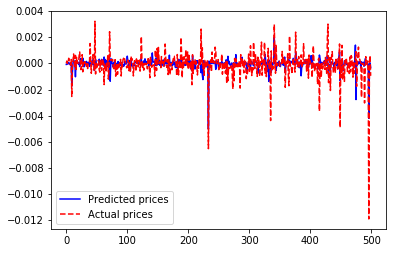

In [90]:
# val=plot_res.shape[0]
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m1= mean_squared_error(res['x'], res['y'])
print("MSE error:",m1)

<h4>b. Intra day returns

In [0]:
%%time
pro =ProgressBar()
# as we plot only Ret_1 for every model to compare test prediction and actual value
plot_res =  pd.DataFrame()
res =  pd.DataFrame()
for Number in pro(range(61,63)): # From 1 to 62
    if Number == 61:
        name_of_column = 'Ret_PlusOne'
        name_of_weight = 'Weight_Daily'
    else:
        name_of_column = 'Ret_PlusTwo'
        name_of_weight = 'Weight_Daily'

    train_targets = training_csv[name_of_column].values
    test_targets = testing_csv[name_of_column].values

    train_weights = training_csv[name_of_weight].values

    data_train = xgb.DMatrix(training_data, label=train_targets, missing=np.NaN, weight=train_weights)
    data_test = xgb.DMatrix(testing_data, missing=np.NaN)
    
    watchlist = [(data_train, 'train')]
    bst = xgb.train(model_parameters,
                    data_train,
                    number_of_rounds,
                    watchlist,
                    early_stopping_rounds=10,
                    verbose_eval=0)

    predictions = bst.predict(data_test)
    if Number is 61:
        plot_res=plot_res.append(pd.DataFrame({'x':bst.predict(data_test).tolist(), 'y':test_targets.tolist()}))

    res=res.append(pd.DataFrame({'x':bst.predict(data_test).tolist(), 'y':test_targets.tolist()}))
    for ID, P in enumerate(predictions):
        major_list.append({'Id': str(ID+1)+'_'+str(Number), 'Predicted': P })

output = pd.DataFrame(data=major_list)
output.sort_values(by='Id', inplace=True)
print(output.head())

100% (2 of 2) |##########################| Elapsed Time: 0:31:10 Time:  0:31:10


            Id  Predicted
999     1000_1   0.000069
8974   1000_61  -0.010980
16949  1000_62  -0.001672
1000    1001_1  -0.000213
8975   1001_61  -0.004094
CPU times: user 1h 1min 21s, sys: 2.22 s, total: 1h 1min 23s
Wall time: 31min 10s


          x         y
0 -0.004701 -0.002939
1  0.004895  0.036104
2  0.006895  0.004728
3  0.002062  0.003166
4  0.003386  0.000229
    Id  Predicted
0  1_1   0.000184
1  2_1  -0.000291
2  3_1   0.000126
3  4_1   0.000080
4  5_1  -0.000064
MSE error: 0.0005016972798379116


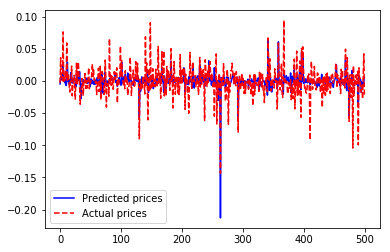

In [0]:
output = output.sort_index(axis = 0) 
output.to_csv("xgboost_Intraday_returns_sol_submission.csv")
print(res.head())
# print(output.head())

# val=plot_res.shape[0]
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m2= mean_squared_error(res['x'], res['y'])
print("MSE error:",m2)
# plot_res.shape

In [165]:
conc.add_row(["XGboost", m1, m2])
print(conc)

+-------------------------+------------------------+---------------------------+
|        Model Name       | MSE for daily returns  | MSE for intra day returns |
+-------------------------+------------------------+---------------------------+
| LSTM With masking layer |  0.000650198712438325  |   1.2613788683900336e-06  |
|         XGboost         | 1.2405071522992503e-06 |   0.0005016972798379116   |
+-------------------------+------------------------+---------------------------+


<H1> 3. Ensemble Technique

<h4>a. Daily returns

In [16]:
df_train, df_test= train_test_split( df, test_size=0.20, random_state=42)
len(df_train.columns)

211

In [0]:
# https://www.programcreek.com/python/example/102434/sklearn.ensemble.ExtraTreesRegressor
res =  pd.DataFrame()
plot_res =  pd.DataFrame()

feature_cols = [col for col in df_train.columns if col not in total] 
pro=ProgressBar()
for i in pro(dailyReturn_cols):
    X_train = df_train[feature_cols]
    X_train = X_train.fillna(0)
    X_test = df_test[feature_cols]
    X_test = X_test.fillna(0)    

    y = df_train[i].astype('float32')
    y = y.fillna(0)
    
    y_p1 = df_test[i].astype('float32')
    y_p1 = y_p1.fillna(0)
    
    classification = ExtraTreesRegressor(n_estimators=10,max_depth=None, min_samples_split=2)   #rf = Pipeline([("scale", StandardScaler()),("rf", RandomForestClassifier(n_estimators=10, 2))])
    X = Imputer().fit_transform(X_train)
    y=y.values.reshape(-1,1)
    y = Imputer().fit_transform(y)
    classification.fit(X_train, y)
    y_pred = classification.predict(X_test)
    
    if i is 'Ret_121':
        plot_res=plot_res.append(pd.DataFrame({'x':y_pred.tolist(), 'y':y_p1.tolist()}))
    res=res.append(pd.DataFrame({'x':y_pred.tolist(), 'y':y_p1.tolist()}))

100% (60 of 60) |########################| Elapsed Time: 0:19:44 Time:  0:19:44


In [0]:
print(plot_res.head())

          x         y
0  0.000245  0.000531
1  0.000221 -0.000597
2  0.000052 -0.000173
3 -0.000186 -0.000201
4 -0.000088  0.000116


MSE error: 1.2636426776403615e-06


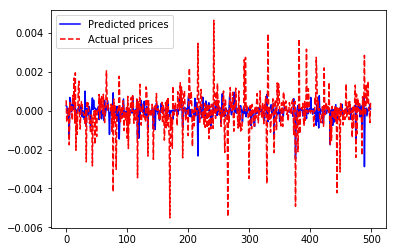

In [0]:
# val=plot_res.shape[0]
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m1= mean_squared_error(res['x'], res['y'])
print("MSE error:",m1)

<h4>b. Intra day returns

In [166]:
# https://www.programcreek.com/python/example/102434/sklearn.ensemble.ExtraTreesRegressor
res =  pd.DataFrame()
plot_res =  pd.DataFrame()

feature_cols = [col for col in df_train.columns if col not in total] 
pro=ProgressBar()
for i in pro(intraDay_cols):
    X_train = df_train[feature_cols]
    X_train = X_train.fillna(0)
    X_test = df_test[feature_cols]
    X_test = X_test.fillna(0)    

    y = df_train[i].astype('float32')
    y = y.fillna(0)
    
    y_p1 = df_test[i].astype('float32')
    y_p1 = y_p1.fillna(0)
    
    classification = ExtraTreesRegressor(n_estimators=10,max_depth=None, min_samples_split=2)   #rf = Pipeline([("scale", StandardScaler()),("rf", RandomForestClassifier(n_estimators=10, 2))])
    X = Imputer().fit_transform(X_train)
    y=y.values.reshape(-1,1)
    y = Imputer().fit_transform(y)
    classification.fit(X_train, y)
    y_pred = classification.predict(X_test)
    
    if i is 'Ret_PlusOne':
        plot_res=plot_res.append(pd.DataFrame({'x':y_pred.tolist(), 'y':y_p1.tolist()}))
    res=res.append(pd.DataFrame({'x':y_pred.tolist(), 'y':y_p1.tolist()}))

100% (2 of 2) |##########################| Elapsed Time: 0:00:38 Time:  0:00:38


          x         y
0  0.005029  0.011966
1 -0.010219 -0.004402
2  0.001798 -0.001938
3  0.010047  0.017789
4 -0.000822  0.007983
MSE error: 0.0006274016286506527


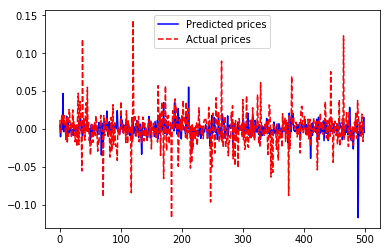

In [167]:
print(plot_res.head())
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m2= mean_squared_error(res['x'], res['y'])
print("MSE error:",m2)

In [168]:
conc.add_row(["ExtraTreesRegressor ", m1, m2])
print(conc)

+-------------------------+------------------------+---------------------------+
|        Model Name       | MSE for daily returns  | MSE for intra day returns |
+-------------------------+------------------------+---------------------------+
| LSTM With masking layer |  0.000650198712438325  |   1.2613788683900336e-06  |
|         XGboost         | 1.2405071522992503e-06 |   0.0005016972798379116   |
|   ExtraTreesRegressor   | 1.2636426776403615e-06 |   0.0006274016286506527   |
+-------------------------+------------------------+---------------------------+


<H1>4. LSTM with 2 hidden layers

In [169]:
model = Sequential()
model.add(Dense(12, input_dim=147, kernel_initializer='normal'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
print(model.summary())

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
# https://stackoverflow.com/questions/48285129/saving-best-model-in-keras


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 12)                1776      
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 9         
Total params: 1,889
Trainable params: 1,889
Non-trainable params: 0
_________________________________________________________________
None


In [170]:
df = pd.read_csv(files_path+'train.csv')
df.fillna(df.mean(axis=0), inplace=True)
X = df.iloc[:,0:147]
msk = np.random.rand(len(X)) < 0.8
print(msk)
x_train=X[msk]
x_test=X[~msk]

[ True  True  True ...  True  True False]


In [0]:
scaler_x = MinMaxScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_test=scaler_x.transform(x_test)

<h4>a. Daily returns

In [172]:
# Y = df.iloc[:,147]
pro=ProgressBar()
for col in pro(dailyReturn_cols):
    Y = df[col]
    y_train=Y[msk]
    y_test=Y[~msk]

    y_train = y_train.astype('float32')
    y_train = y_train.fillna(0)

    y_test = y_test.astype('float32')
    y_test = y_test.fillna(0)
    history = model.fit(x_train, y_train,epochs=10, batch_size=50,callbacks=[earlyStopping, mcp_save],verbose=0)

    if col is 'Ret_121':
        plot_res=plot_res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
    res=res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))

100% (60 of 60) |########################| Elapsed Time: 0:28:24 Time:  0:28:24


          x         y
0  0.005029  0.011966
1 -0.010219 -0.004402
2  0.001798 -0.001938
3  0.010047  0.017789
4 -0.000822  0.007983
MSE error: 3.4314954120847986e-05


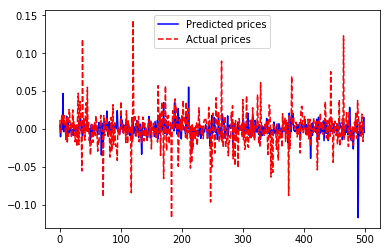

In [173]:
print(plot_res.head())
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m1= mean_squared_error(res['x'], res['y'])
print("MSE error:",m1)

<h4>b. Intra day returns

In [174]:
# Y = df.iloc[:,147]
plot_res=pd.DataFrame()
res=pd.DataFrame()
pro=ProgressBar()
for col in pro(intraDay_cols):
    Y = df[col]
    y_train=Y[msk]
    y_test=Y[~msk]

    y_train = y_train.astype('float32')
    y_train = y_train.fillna(0)

    y_test = y_test.astype('float32')
    y_test = y_test.fillna(0)
    history = model.fit(x_train, y_train,epochs=10, batch_size=50,callbacks=[earlyStopping, mcp_save],verbose=0)

    if col is 'Ret_PlusOne':
        plot_res=plot_res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
    res=res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))

100% (2 of 2) |##########################| Elapsed Time: 0:00:56 Time:  0:00:56


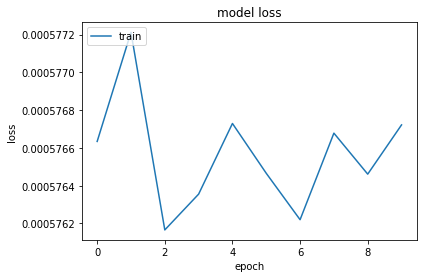

In [175]:
# this last plot is only for last column which is Ret_180
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

          x         y
0 -0.000393 -0.011105
1 -0.000393  0.097741
2 -0.000393 -0.010067
3 -0.000393  0.000229
4 -0.000393 -0.007368
MSE error: 0.0006371389497042122


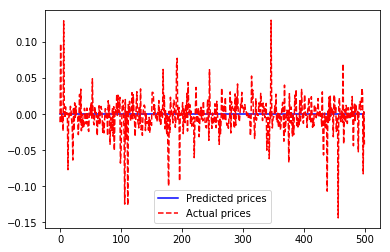

In [176]:
print(plot_res.head())
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m2= mean_squared_error(res['x'].values, res['y'].values)
print("MSE error:",m2)

In [180]:
conc.add_row(["LSTM with 2 hidden layer ", m1, m2])
print(conc)

+---------------------------+------------------------+---------------------------+
|         Model Name        | MSE for daily returns  | MSE for intra day returns |
+---------------------------+------------------------+---------------------------+
|  LSTM With masking layer  |  0.000650198712438325  |   1.2613788683900336e-06  |
|          XGboost          | 1.2405071522992503e-06 |   0.0005016972798379116   |
|    ExtraTreesRegressor    | 1.2636426776403615e-06 |   0.0006274016286506527   |
| LSTM with 2 hidden layer  | 3.4314954120847986e-05 |   0.0006371389497042122   |
+---------------------------+------------------------+---------------------------+


<H1> 5. LSTM with 4 hidden layers

In [115]:
model = Sequential()
model.add(Dense(128, input_dim=147, kernel_initializer='normal'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='linear'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 128)               18944     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 29,553
Trainable params: 29,553
Non-trainable params: 0
_________________________________________________________________
None


In [116]:
df = pd.read_csv(files_path+'train.csv')
df.fillna(df.mean(axis=0), inplace=True)
X = df.iloc[:,0:147]
msk = np.random.rand(len(X)) < 0.8
print(msk)
x_train=X[msk]
x_test=X[~msk]

[ True  True  True ...  True  True False]


In [0]:
scaler_x = MinMaxScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_test=scaler_x.transform(x_test)

<h4>a. Daily returns

In [118]:
# Y = df.iloc[:,147]
plot_res=pd.DataFrame()
res=pd.DataFrame()
pro=ProgressBar()
for col in pro(dailyReturn_cols):
    Y = df[col]
    y_train=Y[msk]
    y_test=Y[~msk]

    y_train = y_train.astype('float32')
    y_train = y_train.fillna(0)

    y_test = y_test.astype('float32')
    y_test = y_test.fillna(0)

    history = model.fit(x_train, y_train,epochs=10, batch_size=50,verbose=0)

    if col is 'Ret_121':
        plot_res=plot_res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
    res=res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))

100% (60 of 60) |########################| Elapsed Time: 0:32:53 Time:  0:32:53


          x         y
0  0.002336 -0.000367
1  0.003032  0.000394
2  0.003263 -0.000191
3  0.000163  0.000010
4  0.004363  0.000006
MSE error: 1.5848400656118064e-06


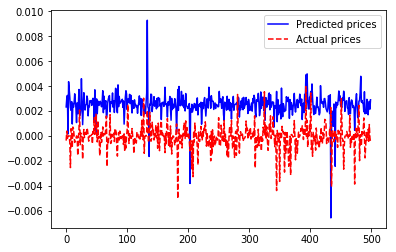

In [119]:
print(plot_res.head())
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m1= mean_squared_error(res['x'], res['y'])
print("MSE error:",m1)

<h4>b. Intra day returns

In [120]:
# Y = df.iloc[:,147]
plot_res=pd.DataFrame()
res=pd.DataFrame()
pro=ProgressBar()
for col in pro(intraDay_cols):
    Y = df[col]
    y_train=Y[msk]
    y_test=Y[~msk]

    y_train = y_train.astype('float32')
    y_train = y_train.fillna(0)

    y_test = y_test.astype('float32')
    y_test = y_test.fillna(0)
    history = model.fit(x_train, y_train,epochs=10, batch_size=50,callbacks=[earlyStopping, mcp_save],verbose=0)

    if col is 'Ret_PlusOne':
        plot_res=plot_res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
    res=res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))

100% (2 of 2) |##########################| Elapsed Time: 0:01:06 Time:  0:01:06


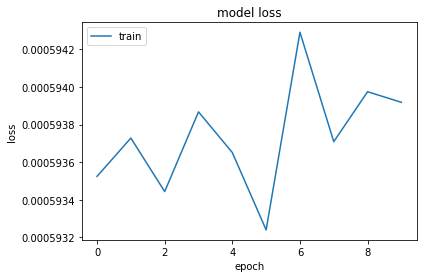

In [121]:
# this last plot is only for last column which is Ret_180
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

          x         y
0 -0.000196 -0.009348
1 -0.000196 -0.010067
2 -0.000196  0.000229
3 -0.000196  0.005781
4 -0.000196  0.129496
MSE error: 0.0005776596093536332


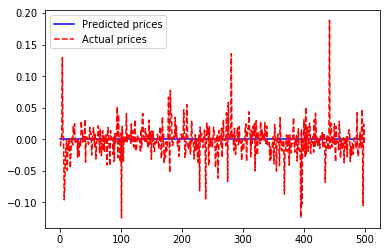

In [122]:
print(plot_res.head())
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m2= mean_squared_error(res['x'].values, res['y'].values)
print("MSE error:",m2)

In [181]:
conc.add_row(["LSTM with 4 hidden layer ", m1, m2])
print(conc)

+---------------------------+------------------------+---------------------------+
|         Model Name        | MSE for daily returns  | MSE for intra day returns |
+---------------------------+------------------------+---------------------------+
|  LSTM With masking layer  |  0.000650198712438325  |   1.2613788683900336e-06  |
|          XGboost          | 1.2405071522992503e-06 |   0.0005016972798379116   |
|    ExtraTreesRegressor    | 1.2636426776403615e-06 |   0.0006274016286506527   |
| LSTM with 2 hidden layer  | 3.4314954120847986e-05 |   0.0006371389497042122   |
| LSTM with 4 hidden layer  | 1.5848400656118064e-06 |   0.0005776596093536332   |
+---------------------------+------------------------+---------------------------+


<h1> 6. LSTM with 4 layers and batch normalization layer

In [182]:
from keras.layers.normalization import BatchNormalization
model = Sequential()
model.add(Dense(128, input_dim=147, kernel_initializer='normal'))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='linear'))
model.add(Dense(1, activation='linear'))
print(model.summary())

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 128)               18944     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                

In [183]:
df = pd.read_csv(files_path+'train.csv')
df.fillna(df.mean(axis=0), inplace=True)
X = df.iloc[:,0:147]
msk = np.random.rand(len(X)) < 0.8
print(msk)
x_train=X[msk]
x_test=X[~msk]

[ True  True  True ...  True False False]


In [0]:
scaler_x = MinMaxScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_test=scaler_x.transform(x_test)

<h4>a. Daily returns

In [185]:

# Y = df.iloc[:,147]
pro=ProgressBar()
for col in pro(dailyReturn_cols):
    Y = df[col]
    y_train=Y[msk]
    y_test=Y[~msk]

    y_train = y_train.astype('float32')
    y_train = y_train.fillna(0)

    y_test = y_test.astype('float32')
    y_test = y_test.fillna(0)
    history = model.fit(x_train, y_train,epochs=10, batch_size=50,callbacks=[earlyStopping, mcp_save],verbose=0)

    if col is 'Ret_121':
        plot_res=plot_res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
    res=res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))

100% (60 of 60) |########################| Elapsed Time: 1:01:02 Time:  1:01:02


          x         y
0 -0.000393 -0.011105
1 -0.000393  0.097741
2 -0.000393 -0.010067
3 -0.000393  0.000229
4 -0.000393 -0.007368
MSE error: 2.1893272052289176e-05


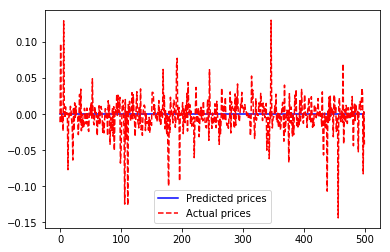

In [186]:
print(plot_res.head())
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m1= mean_squared_error(res['x'], res['y'])
print("MSE error:",m1)

<h4>b. Intra day returns

In [187]:

# Y = df.iloc[:,147]
plot_res=pd.DataFrame()
res=pd.DataFrame()
pro=ProgressBar()
for col in pro(intraDay_cols):
    Y = df[col]
    y_train=Y[msk]
    y_test=Y[~msk]

    y_train = y_train.astype('float32')
    y_train = y_train.fillna(0)

    y_test = y_test.astype('float32')
    y_test = y_test.fillna(0)
    history = model.fit(x_train, y_train,epochs=10, batch_size=50,callbacks=[earlyStopping, mcp_save],verbose=0)

    if col is 'Ret_PlusOne':
        plot_res=plot_res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
    res=res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))

100% (2 of 2) |##########################| Elapsed Time: 0:02:05 Time:  0:02:05


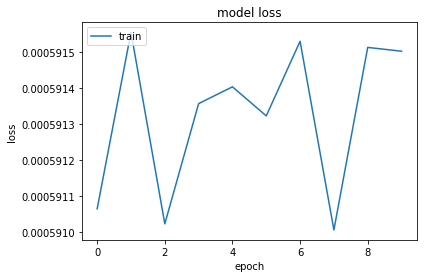

In [188]:
# this last plot is only for last column which is Ret_180
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

          x         y
0 -0.002599  0.003166
1 -0.002599 -0.005204
2 -0.002599  0.003828
3 -0.002599  0.004051
4 -0.002599 -0.011652
MSE error: 0.0006294481172375907


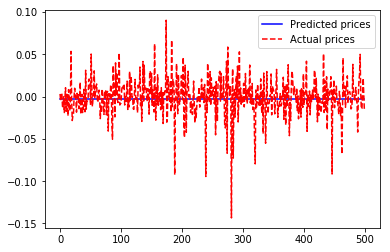

In [189]:
print(plot_res.head())
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m2= mean_squared_error(res['x'].values, res['y'].values)
print("MSE error:",m2)

In [190]:
conc.add_row(["LSTM with 4 hidden layer and batchnormal layers ", m1, m2])
print(conc)

+--------------------------------------------------+------------------------+---------------------------+
|                    Model Name                    | MSE for daily returns  | MSE for intra day returns |
+--------------------------------------------------+------------------------+---------------------------+
|             LSTM With masking layer              |  0.000650198712438325  |   1.2613788683900336e-06  |
|                     XGboost                      | 1.2405071522992503e-06 |   0.0005016972798379116   |
|               ExtraTreesRegressor                | 1.2636426776403615e-06 |   0.0006274016286506527   |
|            LSTM with 2 hidden layer              | 3.4314954120847986e-05 |   0.0006371389497042122   |
|            LSTM with 4 hidden layer              | 1.5848400656118064e-06 |   0.0005776596093536332   |
| LSTM with 4 hidden layer and batchnormal layers  | 2.1893272052289176e-05 |   0.0006294481172375907   |
+---------------------------------------------

Epoch 1/10
40000/40000 [==============================] - 7s 184us/step - loss: 5.8502e-04 - mean_squared_error: 5.8502e-04 - mean_absolute_error: 0.0153
Epoch 2/10
40000/40000 [==============================] - 8s 193us/step - loss: 5.8517e-04 - mean_squared_error: 5.8517e-04 - mean_absolute_error: 0.0153
Epoch 3/10
40000/40000 [==============================] - 8s 194us/step - loss: 5.8539e-04 - mean_squared_error: 5.8539e-04 - mean_absolute_error: 0.0153
Epoch 4/10
40000/40000 [==============================] - 8s 193us/step - loss: 5.8525e-04 - mean_squared_error: 5.8525e-04 - mean_absolute_error: 0.0153
Epoch 5/10
40000/40000 [==============================] - 8s 189us/step - loss: 5.8554e-04 - mean_squared_error: 5.8554e-04 - mean_absolute_error: 0.0153
Epoch 6/10
40000/40000 [==============================] - 8s 193us/step - loss: 5.8555e-04 - mean_squared_error: 5.8555e-04 - mean_absolute_error: 0.0154
Epoch 7/10
40000/40000 [==============================] - 8s 199us/step - lo

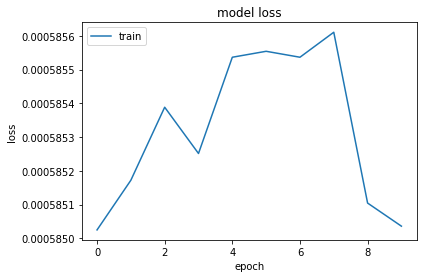

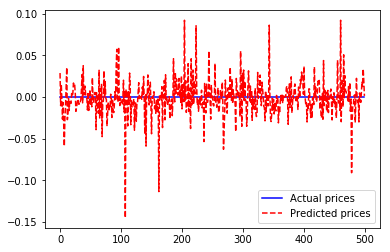

In [131]:
# scaler_x = MinMaxScaler()
# scaler_x.fit(X)
# xscale=scaler_x.transform(X)

# history = model.fit(xscale, Y,epochs=10, batch_size=50)
# plt.plot(history.history['loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train'], loc='upper left')
# plt.show()

# plt.plot(range(0, len(Y[:500])), model.predict(xscale[:500]), 'b-', label='Actual prices')
# plt.plot(range(0, len(Y[:500])), Y[:500], 'r--', label='Predicted prices')
# plt.legend()

<h1>7. RBF kernel SVR

In [191]:
df = pd.read_csv(files_path+'train.csv')
df.fillna(df.mean(axis=0), inplace=True)
X = df.iloc[:,0:147]
msk = np.random.rand(len(X)) < 0.8
print(msk)
x_train=X[msk]
x_test=X[~msk]

[False  True  True ... False  True  True]


<h4>a. Daily returns

In [192]:
# Y = df.iloc[:,147]
pro=ProgressBar()
for col in pro(dailyReturn_cols):
    Y = df[col]
    y_train=Y[msk]
    y_test=Y[~msk]

    y_train = y_train.astype('float32')
    y_train = y_train.fillna(0)

    y_test = y_test.astype('float32')
    y_test = y_test.fillna(0)
    model = SVR(kernel='rbf', C=1e3, gamma=0.1)
    #svr_lin = SVR(kernel='linear', C=1e3)
    #svr_poly = SVR(kernel='poly', C=1e3, degree=2)

    y_rbf = model.fit(x_train, y_train).predict(x_test)
    if col is 'Ret_121':
        plot_res=plot_res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
    res=res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
 

100% (60 of 60) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


          x         y
0 -0.002599  0.003166
1 -0.002599 -0.005204
2 -0.002599  0.003828
3 -0.002599  0.004051
4 -0.002599 -0.011652
MSE error: 0.00011203147433272193


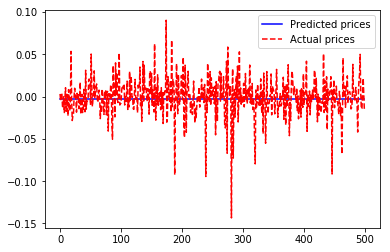

In [193]:
print(plot_res.head())
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m1= mean_squared_error(res['x'], res['y'])
print("MSE error:",m1)

<h4>b. Intra day returns

In [194]:
# Y = df.iloc[:,147]
plot_res=pd.DataFrame()
res=pd.DataFrame()
pro=ProgressBar()
for col in pro(intraDay_cols):
    Y = df[col]
    y_train=Y[msk]
    y_test=Y[~msk]

    y_train = y_train.astype('float32')
    y_train = y_train.fillna(0)

    y_test = y_test.astype('float32')
    y_test = y_test.fillna(0)
    
    model = SVR(kernel='rbf', C=1e3, gamma=0.1)
    #svr_lin = SVR(kernel='linear', C=1e3)
    #svr_poly = SVR(kernel='poly', C=1e3, degree=2)

    model.fit(x_train, y_train)

    if col is 'Ret_PlusOne':
        plot_res=plot_res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
    res=res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
	

100% (2 of 2) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05


          x         y
0  0.006286 -0.019512
1  0.006286  0.031098
2  0.006286 -0.011105
3  0.006286  0.020268
4  0.006286 -0.010936
MSE error: 0.0006476464760422494


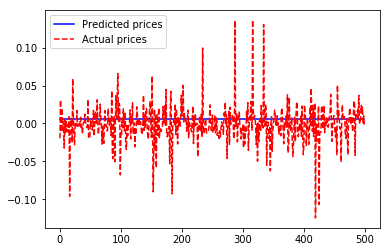

In [195]:

print(plot_res.head())
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m2= mean_squared_error(res['x'].values, res['y'].values)
print("MSE error:",m2)

In [196]:
conc.add_row(["RBF kernel SVR ", m1, m2])
print(conc)

+--------------------------------------------------+------------------------+---------------------------+
|                    Model Name                    | MSE for daily returns  | MSE for intra day returns |
+--------------------------------------------------+------------------------+---------------------------+
|             LSTM With masking layer              |  0.000650198712438325  |   1.2613788683900336e-06  |
|                     XGboost                      | 1.2405071522992503e-06 |   0.0005016972798379116   |
|               ExtraTreesRegressor                | 1.2636426776403615e-06 |   0.0006274016286506527   |
|            LSTM with 2 hidden layer              | 3.4314954120847986e-05 |   0.0006371389497042122   |
|            LSTM with 4 hidden layer              | 1.5848400656118064e-06 |   0.0005776596093536332   |
| LSTM with 4 hidden layer and batchnormal layers  | 2.1893272052289176e-05 |   0.0006294481172375907   |
|                 RBF kernel SVR              

<H1> Linear regression

<h4>a. Daily returns

In [197]:
# Y = df.iloc[:,147]
pro=ProgressBar()
for col in pro(dailyReturn_cols):
    Y = df[col]
    y_train=Y[msk]
    y_test=Y[~msk]

    y_train = y_train.astype('float32')
    y_train = y_train.fillna(0)

    y_test = y_test.astype('float32')
    y_test = y_test.fillna(0)
    model = LinearRegression()

    y_rbf = model.fit(x_train, y_train).predict(x_test)
    if col is 'Ret_121':
        plot_res=plot_res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
    res=res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
 

100% (60 of 60) |########################| Elapsed Time: 0:00:27 Time:  0:00:27


          x         y
0  0.006286 -0.019512
1  0.006286  0.031098
2  0.006286 -0.011105
3  0.006286  0.020268
4  0.006286 -0.010936
MSE error: 2.227150463237327e-05


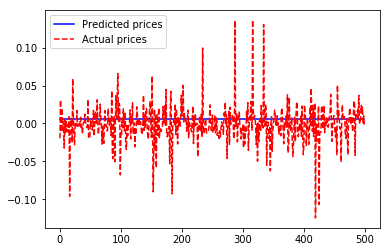

In [198]:
print(plot_res.head())
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m1= mean_squared_error(res['x'], res['y'])
print("MSE error:",m1)

<h4>b. Intra day returns

In [199]:
# Y = df.iloc[:,147]
plot_res=pd.DataFrame()
res=pd.DataFrame()
pro=ProgressBar()
for col in pro(intraDay_cols):
    Y = df[col]
    y_train=Y[msk]
    y_test=Y[~msk]

    y_train = y_train.astype('float32')
    y_train = y_train.fillna(0)

    y_test = y_test.astype('float32')
    y_test = y_test.fillna(0)
    
    model = LinearRegression()
    #svr_lin = SVR(kernel='linear', C=1e3)
    #svr_poly = SVR(kernel='poly', C=1e3, degree=2)

    model.fit(x_train, y_train)

    if col is 'Ret_PlusOne':
        plot_res=plot_res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
    res=res.append(pd.DataFrame({'x':model.predict(x_test).flatten().tolist(), 'y':y_test.tolist()}))
	

100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


          x         y
0  0.006958 -0.019512
1 -0.001696  0.031098
2 -0.004265 -0.011105
3 -0.004253  0.020268
4  0.002089 -0.010936
MSE error: 0.0005815655752938785


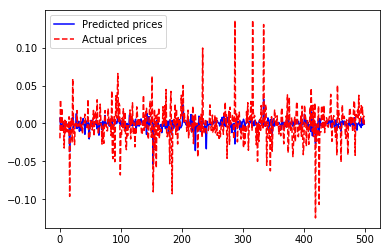

In [200]:

print(plot_res.head())
val=500
plt.plot(range(0, val), plot_res['x'][:val], 'b-', label='Predicted prices')
plt.plot(range(0, val), plot_res['y'][:val], 'r--', label='Actual prices')
plt.legend()

m2= mean_squared_error(res['x'].values, res['y'].values)
print("MSE error:",m2)

In [201]:
conc.add_row(["Linear regression ", m1, m2])
print(conc)

+--------------------------------------------------+------------------------+---------------------------+
|                    Model Name                    | MSE for daily returns  | MSE for intra day returns |
+--------------------------------------------------+------------------------+---------------------------+
|             LSTM With masking layer              |  0.000650198712438325  |   1.2613788683900336e-06  |
|                     XGboost                      | 1.2405071522992503e-06 |   0.0005016972798379116   |
|               ExtraTreesRegressor                | 1.2636426776403615e-06 |   0.0006274016286506527   |
|            LSTM with 2 hidden layer              | 3.4314954120847986e-05 |   0.0006371389497042122   |
|            LSTM with 4 hidden layer              | 1.5848400656118064e-06 |   0.0005776596093536332   |
| LSTM with 4 hidden layer and batchnormal layers  | 2.1893272052289176e-05 |   0.0006294481172375907   |
|                 RBF kernel SVR              

<H1>Conclusion

In [202]:
print(conc)

+--------------------------------------------------+------------------------+---------------------------+
|                    Model Name                    | MSE for daily returns  | MSE for intra day returns |
+--------------------------------------------------+------------------------+---------------------------+
|             LSTM With masking layer              |  0.000650198712438325  |   1.2613788683900336e-06  |
|                     XGboost                      | 1.2405071522992503e-06 |   0.0005016972798379116   |
|               ExtraTreesRegressor                | 1.2636426776403615e-06 |   0.0006274016286506527   |
|            LSTM with 2 hidden layer              | 3.4314954120847986e-05 |   0.0006371389497042122   |
|            LSTM with 4 hidden layer              | 1.5848400656118064e-06 |   0.0005776596093536332   |
| LSTM with 4 hidden layer and batchnormal layers  | 2.1893272052289176e-05 |   0.0006294481172375907   |
|                 RBF kernel SVR              

1. Out of 852 teams that used this data, only 370 (43%) did better than predicting 0 for every stock price.
2. The Model 1 (LSTM with masking) doesn't get improve if we replace the NaN values with median and mean in train and test data.
3. For Daily Returns XGboost has less MSE and LSTM's worked well for sequence data.
4. For Intra day Returns LSTM with masking layer has less MSE.


<h1>References</h1>

http://blog.kaggle.com/2016/02/12/winton-stock-market-challenge-winners-interview-3rd-place-mendrika-ramarlina/

https://medium.com/better-programming/handling-missing-data-in-python-using-scikit-imputer-7607c8957740

https://www.kaggle.com/c/the-winton-stock-market-challenge/discussion

https://navinjain.blog/2018/12/02/the-winton-stock-market-challenge/

https://github.com/KhaledSharif/winton-stock-market/blob/master/submission.py